# CNN - Convolutional Neural Network

Deep Learning.....  

In [28]:
from numpy import array 
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D
from datetime import timedelta, date
from dateutil. relativedelta import relativedelta

import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
dados = pd.read_csv('datasets/dados.csv')
dados = dados.rename(columns={'Unnamed: 0':'mes'})
dados = dados.set_index('mes')

No [Passo 2](passo2.ipynb), a partir do teste de Granger, as seguintes variáriveis foram escolhidas para entrarem no modelo:


In [21]:
dados = dados[['ibc','pib','consumo','ICST-R','geracaoGWh','IndGeral','total']]

In [22]:
dados

,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral,total
mes,,,,,,,
2014-01-01,2.75,455935.0,4.027976e+07,97.8,50045.962407,53.1,13427897
2014-02-01,3.13,450358.8,4.165349e+07,96.7,46459.730274,52.3,14152120
2014-03-01,3.09,462159.8,4.026943e+07,96.3,48004.277170,52.4,13710770
2014-04-01,2.37,468767.5,3.959185e+07,92.6,45412.583753,49.2,12602895
2014-05-01,2.23,473347.1,3.910050e+07,94.6,44890.282526,47.9,14603442
...,...,...,...,...,...,...,...
2020-08-01,-3.35,628818.8,3.912152e+07,87.8,45954.347797,57.0,33983713
2020-09-01,-3.56,632047.2,4.020856e+07,91.5,46045.040560,61.6,32205815
2020-10-01,-3.94,660199.5,4.245064e+07,95.2,46098.056273,61.8,33749277


In [23]:
# split a multivariate sequence into samples 
def split_sequences(sequences, n_steps): 
    X, y = list(), list() 
    for i in range(len(sequences)): 
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the dataset 
        if end_ix == len(sequences): 
            break
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1] 
        X.append(seq_x) 
        y.append(seq_y)
    return array(X), array(y)

In [24]:
# número de steps para considerar no modelo
n_steps = 12

# primeiro mês para prever a demanda (janeiro de 2020)
# resultado das vendas de janeiro é função dos eventos ocorrido em janeiro
# mais os eventos (variáveis) ocorridos em n-1 steps atrás

dataset = dados.to_numpy()

# dados de 2014 até final 2019
train = dataset[0:72]

# valores da variável totoal de jan/2020 até dez/2020
# este é o que queremos prever
y_2020 = dataset[72:84,-1]

# convert into input/output
X, y = split_sequences(train, n_steps)

print(X.shape, y.shape)

# the dataset knows the number of features, e.g. 2 
n_features = X.shape[2]

(60, 12, 6) (60,)


In [25]:
model = Sequential() 
model.add(Conv1D(filters=64, kernel_size=2, activation='relu' , input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten()) 
model.add(Dense(50, activation='relu' )) 
model.add(Dense(1)) 
model.compile(optimizer='adam' , loss='mse' )

model.fit(X, y, epochs=1000, verbose=0)

In [26]:
#### PREDICAO dos totais em 2020 ####

# split a multivariate sequence into samples 
def split_sequences_pred(sequences, n_steps): 
    X = list()
    for i in range(len(sequences)): 
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the dataset 
        if end_ix == len(sequences): 
            break
        # gather input and output parts of the pattern 
        seq_x = sequences[i:end_ix, :-1]
        X.append(seq_x) 
    return array(X)

begin_ix = 72-n_steps #72 é posição onde está janeiro 2020
dataset_X_pred = dataset[begin_ix:83, :-1] #83 é novembro, pois max que vamos é até dez/20

def split_sequences_pred(sequences, n_steps):
    X = list()
    for i in range(12):
        end = len(sequences)-i
        seq_x = sequences[end-n_steps:end]
        X.append(seq_x) 
    return array(X)

X_pred = split_sequences_pred(dataset_X_pred , n_steps)
#começa em -1 e vai diminuindo
y_pred = list()
for i in range(12):
    X=X_pred[-1-i].reshape(1,n_steps,n_features)
    yhat = model.predict(X, verbose=0)
    y_pred.append(yhat[0][0])

In [27]:
y_pred/y_2020

array([0.77092692, 0.75376116, 1.11609215, 0.8706859 , 0.90793886,
       0.63268914, 0.49213768, 0.63707647, 0.68123108, 0.63454906,
       0.60071395, 0.59929337])

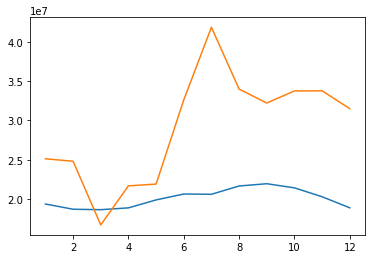

In [29]:
d = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(d,y_pred,d,y_2020)
plt.show()